# Wearable Sensor Case Study: VAE for Breathing Anomaly Detection

**Goal:** Learn *normal breathing* from a wearable respiration signal (e.g., chest belt / torso IMU / PPG-derived respiration proxy) and detect anomalies such as:
- **apnea-like** (near-flat signal for several seconds),
- **erratic** breathing (irregular rate/amplitude),
- **motion artifacts** (bursts/steps),
- **low-SNR** segments.

We train a **VAE** on *normal* windows only, then use an anomaly score:
$S(x)=\text{reconstruction}(x)+\beta\,\text{KL}(q_\phi(z\mid x)\|p(z)).$

> The data below is synthetic-but-realistic (drift, noise, variability), so you can run this offline and later swap in real wearable data.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import roc_auc_score, roc_curve

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1) Simulate wearable respiration windows

# Normal vs Abnormal Breathing Characteristics Learned by the VAE

## Normal signals have:
- **random base frequency** in the range **[0.18, 0.32] Hz**
- **slow frequency modulation** (natural breath‑to‑breath variability)
- **random amplitude**
- **random phase**
- **drift + noise** (simulating wearable artifacts)

Because of these factors:

### ✔ Breathing frequency varies significantly from window to window  
Normal breathing is *not* generated with a single fixed frequency.

### ✔ The decoder does **not** detect anomalies based on frequency alone  
Instead, it learns a **distribution** of normal breathing dynamics.

Anomalies stand out because they have:
- **wrong shape** (apnea → flatline)
- **wrong dynamics** (erratic rate/amplitude spikes)
- **wrong distribution** (motion bursts not seen during training)
- **wrong noise characteristics** (low SNR segments)

---

# 🎯 How does the VAE detect anomalies?

The VAE learns the **manifold of normal breathing**, which includes:

- valid breathing cycles  
- the allowed range of breathing frequencies  
- expected smoothness  
- moderate drift  
- moderate noise  

When a signal deviates from this manifold, reconstruction becomes poor and/or the latent encoding deviates from the prior.

---

## 📌 Example Behaviors

### **Apnea**
- Flat or nearly flat signal  
- Cannot be represented by normal sinusoidal patterns  
- → **Reconstruction error increases**

### **Erratic breathing**
- Sudden large changes in frequency or shape  
- Latent representation moves away from N(0,1)  
- → **KL divergence increases**

### **Motion artifacts**
- Sharp bursts or steps the decoder has never seen  
- → **Reconstruction error increases**

### **Low SNR**
- Noise dominates the breathing structure  
- Decoder reconstructs a smoother signal  
- → **Reconstruction error increases**

---

# Key Insight
➡ **Anomaly detection comes from deviations from the learned normal manifold — not from deviation from a single breathing frequency.**

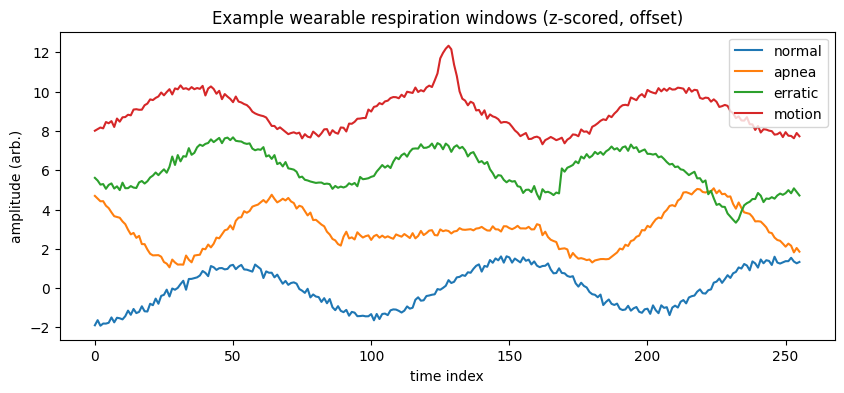

In [ ]:
def simulate_breathing_window(fs=20, T=256, kind="normal"):
    """Return (x, label_info). x mimics a respiration belt/IMU respiration proxy."""
    t = np.arange(T) / fs

    # Normal respiration: ~0.15–0.35 Hz (9–21 breaths/min)
    fr = np.random.uniform(0.18, 0.32)
    A = np.random.uniform(0.8, 1.2)
    phase = np.random.uniform(0, 2*np.pi)

    # Add mild breath-to-breath variability by frequency modulation
    fm = np.random.uniform(0.01, 0.04)  # slow mod rate
    fr_t = fr * (1.0 + 0.08*np.sin(2*np.pi*fm*t + np.random.uniform(0,2*np.pi)))

    # Build signal via integrating instantaneous frequency
    phi = 2*np.pi*np.cumsum(fr_t)/fs + phase
    resp = A * np.sin(phi)

    # Wearable nuisances
    drift = 0.25 * np.sin(2*np.pi*np.random.uniform(0.02, 0.06)*t + np.random.uniform(0,2*np.pi))
    noise = np.random.normal(0, np.random.uniform(0.05, 0.12), size=T)

    # Occasional slight baseline shift
    if np.random.rand() < 0.2:
        shift = np.random.uniform(-0.4, 0.4)
        resp = resp + shift*(t > t[np.random.randint(T//3, 2*T//3)])

    x = resp + drift + noise
    info = f"fr~{fr:.2f}Hz"

    if kind == "apnea":
        # Flat (or nearly flat) respiration for a sustained interval
        start = np.random.randint(T//4, T//2)
        dur = np.random.randint(T//4, T//2)
        mask = np.ones(T, dtype=np.float32)
        mask[start:start+dur] = np.random.uniform(0.0, 0.12)  # suppress amplitude
        x = (resp*mask) + drift + noise
        info += " | apnea-like suppression"
    elif kind == "erratic":
        # Irregular rate + amplitude spikes (e.g., arousal, coughing, obstruction)
        fr2 = np.random.uniform(0.12, 0.55)
        A2 = np.random.uniform(0.5, 1.6)
        phi2 = 2*np.pi*fr2*t + np.random.uniform(0,2*np.pi)
        resp2 = A2 * np.sin(phi2)

        # Mix segments with different rates/amplitudes
        cut = np.random.randint(T//3, 2*T//3)
        x = np.concatenate([resp[:cut], resp2[cut:]]) + drift + noise
        # Add a couple of irregular pulses
        for _ in range(np.random.randint(1,4)):
            p = np.random.randint(0, T-12)
            x[p:p+12] += np.random.uniform(-1.2, 1.2) * np.hanning(12)
        info += " | erratic"
    elif kind == "motion":
        # Big transient burst + step (movement)
        burst_pos = np.random.randint(T//4, 3*T//4)
        burst = np.zeros(T)
        burst[burst_pos:burst_pos+14] = np.random.uniform(2.0, 4.0) * np.hanning(14)
        step = np.random.uniform(-1.5, 1.5) * (t > t[burst_pos])
        x = x + burst + 0.25*step
        info += " | motion artifact"
    elif kind == "lowSNR":
        x = resp + drift + np.random.normal(0, np.random.uniform(0.18, 0.35), size=T)
        info += " | low SNR"

    return x.astype(np.float32), info

def zscore_per_window(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-6
    return (X - mu) / sd

# Build datasets
def make_dataset(n_normal=5000, n_abn_each=800, fs=20, T=256):
    Xn = np.stack([simulate_breathing_window(fs, T, "normal")[0] for _ in range(n_normal)])
    kinds = ["apnea","erratic","motion","lowSNR"]
    Xa = []
    ya = []
    for k in kinds:
        for _ in range(n_abn_each):
            x,_ = simulate_breathing_window(fs, T, k)
            Xa.append(x); ya.append(k)
    Xa = np.stack(Xa)
    ya = np.array(ya)
    return zscore_per_window(Xn), zscore_per_window(Xa), ya

fs, T = 20, 256
X_normal, X_abn, y_abn = make_dataset(fs=fs, T=T)

# Quick visualization
plt.figure(figsize=(10,4))
for i, kind in enumerate(["normal","apnea","erratic","motion"]):
    x, info = simulate_breathing_window(fs, T, kind)
    x = (x - x.mean())/(x.std()+1e-6)
    plt.plot(x + 3*i, label=kind)
plt.title("Example wearable respiration windows (z-scored, offset)")
plt.xlabel("time index"); plt.ylabel("amplitude (arb.)")
plt.legend()
plt.show()

## 2) VAE (small 1D Conv encoder/decoder)


The entire system trains a β-VAE on **normal breathing only**, so that:
- Normal patterns yield low reconstruction error and low KL.
- Anomalous windows (apnea, erratic breathing, motion artifacts, low SNR) will:
  - reconstruct poorly → ↑ MSE
  - map to unusual latent z → ↑ KL
- Combined anomaly score:
    S(x) = recon(x) + β·KL(x)

Thus the trained model becomes a *normality model* for respiration.


In [ ]:
class Encoder1D(nn.Module):
    def __init__(self, T=256, latent_dim=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1,1,T)
            h = self.conv(dummy)
            self.L = h.shape[-1]
            self.flat_dim = h.numel()

        self.fc = nn.Linear(self.flat_dim, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = self.conv(x.unsqueeze(1)).reshape(x.size(0), -1)
        h = F.relu(self.fc(h))
        return self.mu(h), self.logvar(h)

class Decoder1D(nn.Module):
    def __init__(self, T=256, latent_dim=8, flat_dim=None, L=None):
        super().__init__()
        assert flat_dim is not None and L is not None
        self.T = T
        self.L = L
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, flat_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=2, padding=4, output_padding=1),
        )

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = self.fc2(h).view(z.size(0), 64, self.L)
        xhat = self.deconv(h).squeeze(1)
        # crop/pad to exact length
        if xhat.size(1) > self.T:
            xhat = xhat[:, :self.T]
        elif xhat.size(1) < self.T:
            xhat = F.pad(xhat, (0, self.T - xhat.size(1)))
        return xhat

def reparameterize(mu, logvar):
    eps = torch.randn_like(mu)
    return mu + torch.exp(0.5*logvar) * eps

def kl_diag_gauss_to_stdnormal(mu, logvar):
    return 0.5 * torch.sum(mu**2 + torch.exp(logvar) - 1.0 - logvar, dim=-1)

In [ ]:
latent_dim = 8
enc = Encoder1D(T=T, latent_dim=latent_dim).to(device)
dec = Decoder1D(T=T, latent_dim=latent_dim, flat_dim=enc.flat_dim, L=enc.L).to(device)

opt = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=2e-3)
print("L =", enc.L, "| flat_dim =", enc.flat_dim)

L = 32 | flat_dim = 2048


## 3) Train on normal windows only

### 1. Model Assumptions
We assume:
- Latent prior:  
  $
  p(z) = \mathcal{N}(0, I)
  $
- Approximate posterior (encoder):  
  $
  q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x)))
  $
- Gaussian decoder:  
  $
  p_\theta(x|z) = \mathcal{N}(\hat{x}_\theta(z), \sigma^2 I)
  $
  where the decoder outputs only the mean $\hat{x}$, and $\sigma^2$ is fixed.

### 2. Goal: Maximize Log‑Evidence
The quantity we want to maximize is:
$
\log p_\theta(x)
$
But this integral is intractable:
$
p_\theta(x) = \int p_\theta(x|z)p(z)\,dz
$

### 3. Variational Trick
Introduce the encoder distribution $q_\phi(z|x)$ and write:
$
\log p(x)
= \mathbb{E}_{q(z|x)}[\log p(x)].
$

Insert $q(z|x)$ inside the log:
$
\log p(x)
= \mathbb{E}_{q(z|x)}
\left[
\log\frac{p(x,z)}{p(z|x)}
\right].
$

Add and subtract $\log q(z|x)$:
$
\log p(x)
= \mathbb{E}_{q(z|x)}\left[
\log\frac{p(x,z)}{q(z|x)}
\right]
+ \mathrm{KL}(q(z|x)\|p(z|x)).
$

Since KL is ≥ 0:
$
\log p(x) \ge
\mathbb{E}_{q(z|x)}[\log p(x,z) - \log q(z|x)].
$

This defines the **ELBO**:
$
\text{ELBO} =
\mathbb{E}_{q(z|x)}[\log p(x|z)]
- \mathrm{KL}(q(z|x)\|p(z)).
$

Maximizing ELBO ≡ maximizing log evidence.

---

### 4. First Term: Gaussian Likelihood → MSE
Because:
$
p(x|z)=\mathcal{N}(\hat{x}, \sigma^2 I)
$

The log-likelihood is:
$
\log p(x|z)
= -\frac{1}{2\sigma^2}\|x-\hat{x}\|_2^2
    - \frac{D}{2}\log(2\pi\sigma^2).
$

The second term is a constant.
Thus, maximizing $\log p(x|z)$ is equivalent to **minimizing MSE**:
$
-\mathbb{E}_{q(z|x)}[\log p(x|z)]
\propto
\|x-\hat{x}\|_2^2.
$

This justifies the reconstruction loss used in code:
$
\text{recon}(x,\hat{x}) = \|x-\hat{x}\|_2^2.
$

---

### 5. Second Term: KL Between Two Gaussians
Since:
$
q(z|x)=\mathcal{N}(\mu,\mathrm{diag}(\sigma^2))
,\quad
p(z)=\mathcal{N}(0,I)
$

The KL has a closed form:
$
\mathrm{KL}(q(z|x)\|p(z))
= \frac{1}{2}\sum_i (\mu_i^2 + \sigma_i^2 - 1 - \log\sigma_i^2).
$

This is exactly the KL function in your implementation.

---

### 6. Final ELBO Objective
The final (negative) ELBO to minimize is:

$
\mathcal{L}(x) =
\underbrace{
\|x-\hat{x}\|_2^2
}_{\text{Gaussian reconstruction (MSE)}}
+
\underbrace{
\mathrm{KL}(q(z|x)\|p(z))
}_{\text{regularizes latent space}}.
$

With a $\beta$ coefficient (β‑VAE):
$
\mathcal{L}(x) =
\text{MSE}(x,\hat{x}) + \beta \, \mathrm{KL}.
$



In [ ]:
# =========================
# TRAINING WITH HISTORY
# =========================

# Train/val split on normal-only windows
idx = np.random.permutation(len(X_normal))
train_idx, val_idx = idx[:4000], idx[4000:]

X_train = torch.from_numpy(X_normal[train_idx]).to(device)
X_val   = torch.from_numpy(X_normal[val_idx]).to(device)

train_loader = DataLoader(TensorDataset(X_train), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val),   batch_size=512, shuffle=False)

beta = 0.2  # anomaly detection often benefits from a modest beta

def vae_loss_components(x):
    """
    Returns:
      loss: scalar tensor = mean(recon + beta*KL)
      recon_vec: per-sample reconstruction error (sum of squared errors over time)
      kl_vec: per-sample KL(q(z|x)||p(z))
      xhat: reconstruction
      mu, logvar: encoder outputs
    """
    mu, logvar = enc(x)
    z = reparameterize(mu, logvar)
    xhat = dec(z)

    recon_vec = F.mse_loss(xhat, x, reduction="none").sum(dim=-1)
    kl_vec = kl_diag_gauss_to_stdnormal(mu, logvar)
    loss = (recon_vec + beta * kl_vec).mean()
    return loss, recon_vec, kl_vec, xhat, mu, logvar

history = {
    "train_obj": [],   # recon + beta*KL (negative ELBO-like objective)
    "train_recon": [],
    "train_kl": [],
    "val_obj": [],
    "val_recon": [],
    "val_kl": []
}

num_epochs = 60

for epoch in range(num_epochs):
    enc.train(); dec.train()
    batch_objs, batch_recons, batch_kls = [], [], []

    for (xb,) in train_loader:
        loss, recon_vec, kl_vec, _, _, _ = vae_loss_components(xb)

        opt.zero_grad()
        loss.backward()
        opt.step()

        batch_objs.append(loss.item())
        batch_recons.append(recon_vec.mean().item())
        batch_kls.append(kl_vec.mean().item())

    # training epoch averages
    train_obj = float(np.mean(batch_objs))
    train_recon = float(np.mean(batch_recons))
    train_kl = float(np.mean(batch_kls))

    # validation
    enc.eval(); dec.eval()
    v_objs, v_recons, v_kls = [], [], []
    with torch.no_grad():
        for (xb,) in val_loader:
            vloss, vrecon_vec, vkl_vec, _, _, _ = vae_loss_components(xb)
            v_objs.append(vloss.item())
            v_recons.append(vrecon_vec.mean().item())
            v_kls.append(vkl_vec.mean().item())

    val_obj = float(np.mean(v_objs))
    val_recon = float(np.mean(v_recons))
    val_kl = float(np.mean(v_kls))

    history["train_obj"].append(train_obj)
    history["train_recon"].append(train_recon)
    history["train_kl"].append(train_kl)
    history["val_obj"].append(val_obj)
    history["val_recon"].append(val_recon)
    history["val_kl"].append(val_kl)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"epoch {epoch+1:2d} | "
            f"train obj {train_obj:.2f} (recon {train_recon:.2f}, KL {train_kl:.2f}) | "
            f"val obj {val_obj:.2f} (recon {val_recon:.2f}, KL {val_kl:.2f})"
        )


epoch  1 | train obj 172.64 (recon 169.25, KL 16.95) | val obj 66.19 (recon 61.66, KL 22.67)
epoch 10 | train obj 11.43 (recon 7.31, KL 20.62) | val obj 11.36 (recon 7.19, KL 20.86)
epoch 20 | train obj 9.77 (recon 5.73, KL 20.22) | val obj 9.86 (recon 5.78, KL 20.41)
epoch 30 | train obj 9.41 (recon 5.42, KL 19.95) | val obj 9.57 (recon 5.53, KL 20.22)
epoch 40 | train obj 9.25 (recon 5.33, KL 19.58) | val obj 9.24 (recon 5.29, KL 19.78)
epoch 50 | train obj 8.98 (recon 5.13, KL 19.26) | val obj 9.16 (recon 5.37, KL 18.96)
epoch 60 | train obj 9.11 (recon 5.28, KL 19.16) | val obj 9.17 (recon 5.42, KL 18.71)


## 4) Score normal vs abnormal windows (apnea, erratic, motion, low-SNR)

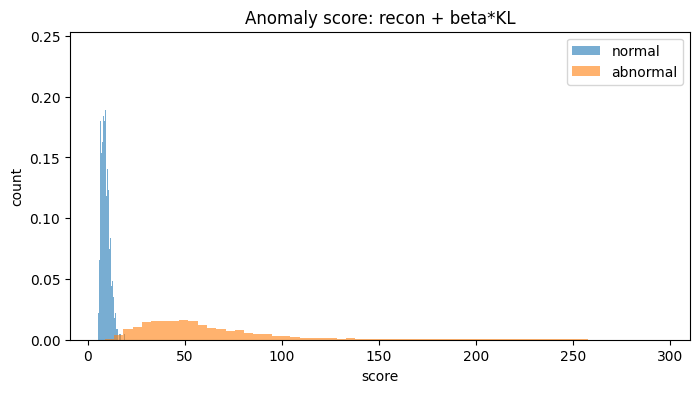

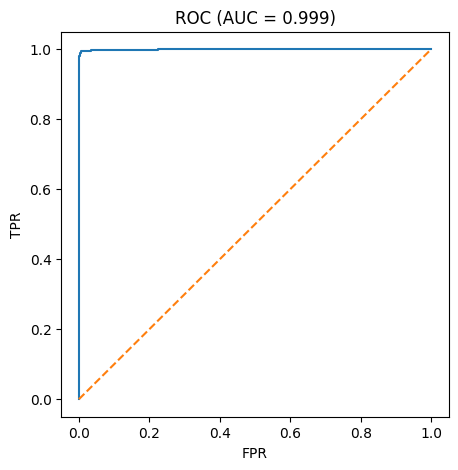

In [ ]:
def score_windows(X):
    enc.eval(); dec.eval()
    X_t = torch.from_numpy(X).to(device)
    with torch.no_grad():
        mu, logvar = enc(X_t)
        z = reparameterize(mu, logvar)
        xhat = dec(z)

        recon = F.mse_loss(xhat, X_t, reduction="none").sum(dim=-1)
        kl = kl_diag_gauss_to_stdnormal(mu, logvar)
        score = recon + beta*kl
    return score.cpu().numpy(), xhat.cpu().numpy(), mu.cpu().numpy()

X_test_normal = X_normal[val_idx]  # held-out normal
s_n, xhat_n, _ = score_windows(X_test_normal)
s_a, xhat_a, _ = score_windows(X_abn)

plt.figure(figsize=(8,4))
plt.hist(s_n, bins=60, density=True, alpha=0.6, label="normal")
plt.hist(s_a, bins=60, density=True, alpha=0.6, label="abnormal")
plt.title("Anomaly score: recon + beta*KL")
plt.xlabel("score"); plt.ylabel("count")
plt.legend()
plt.show()

y_true = np.concatenate([np.zeros_like(s_n), np.ones_like(s_a)])
scores = np.concatenate([s_n, s_a])

auc = roc_auc_score(y_true, scores)
fpr, tpr, _ = roc_curve(y_true, scores)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

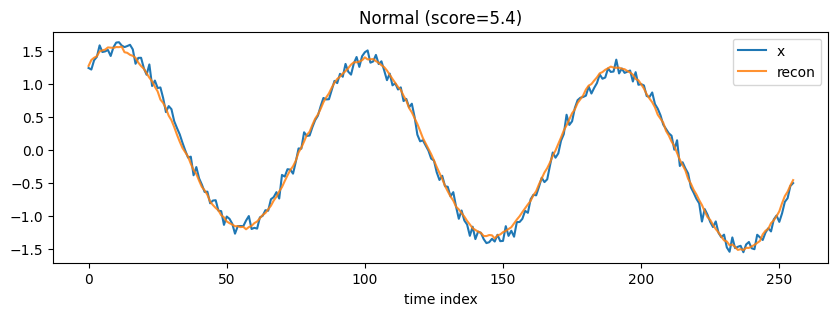

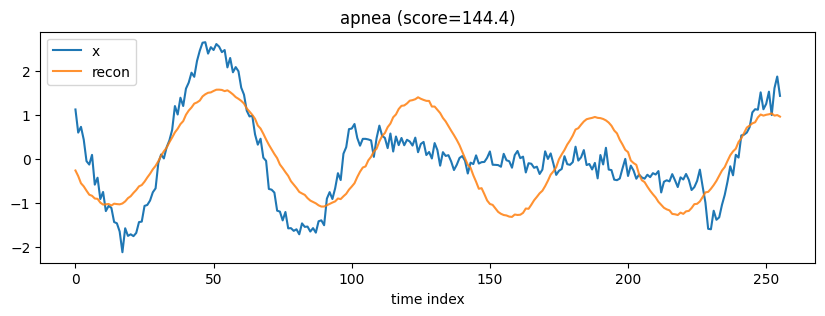

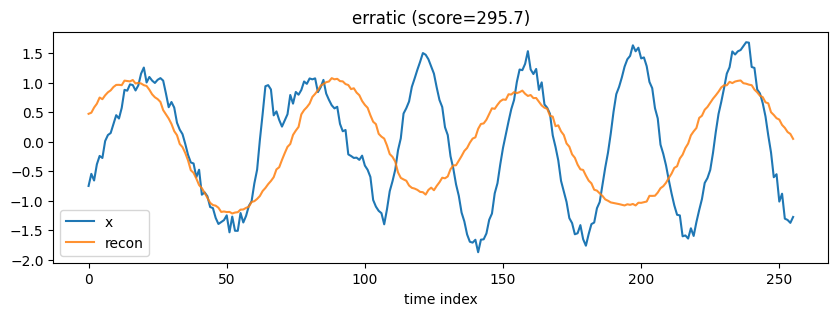

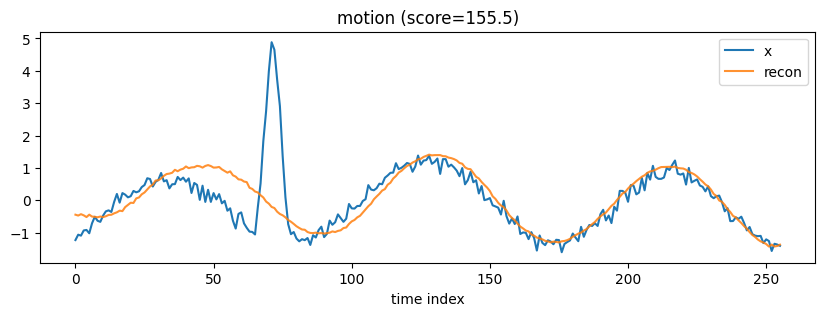

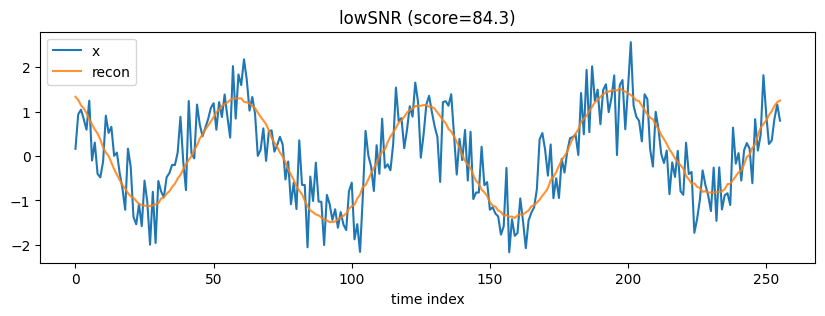

In [ ]:
# Show reconstructions: one normal + examples of each anomaly type
def plot_pair(x, xhat, title):
    plt.figure(figsize=(10,3))
    plt.plot(x, label="x")
    plt.plot(xhat, label="recon", alpha=0.85)
    plt.title(title)
    plt.xlabel("time index")
    plt.legend()
    plt.show()

# Pick a low-score normal
i_n = int(np.argmin(s_n))
plot_pair(X_test_normal[i_n], xhat_n[i_n], f"Normal (score={s_n[i_n]:.1f})")

# For each anomaly kind, pick a high-score example from that kind
for k in ["apnea","erratic","motion","lowSNR"]:
    idx_k = np.where(y_abn == k)[0]
    sk = s_a[idx_k]
    j = idx_k[int(np.argmax(sk))]
    plot_pair(X_abn[j], xhat_a[j], f"{k} (score={s_a[j]:.1f})")

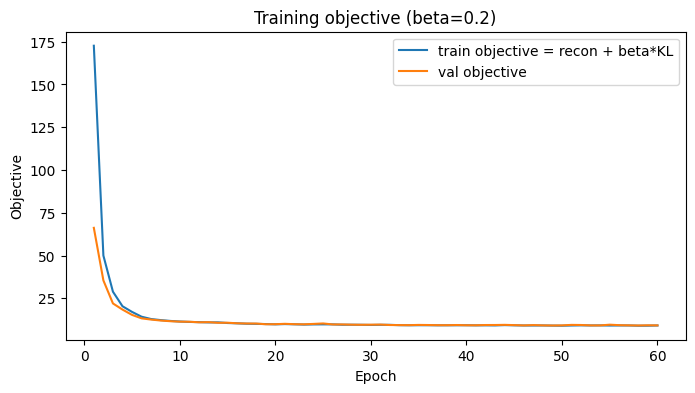

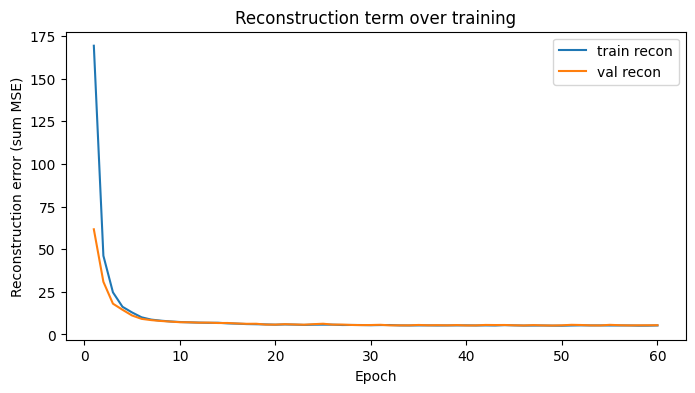

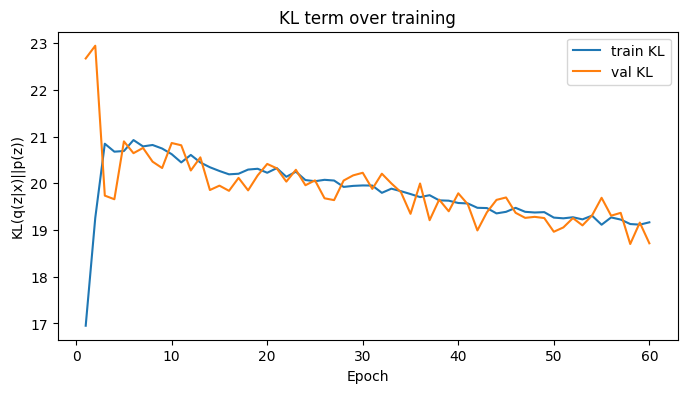

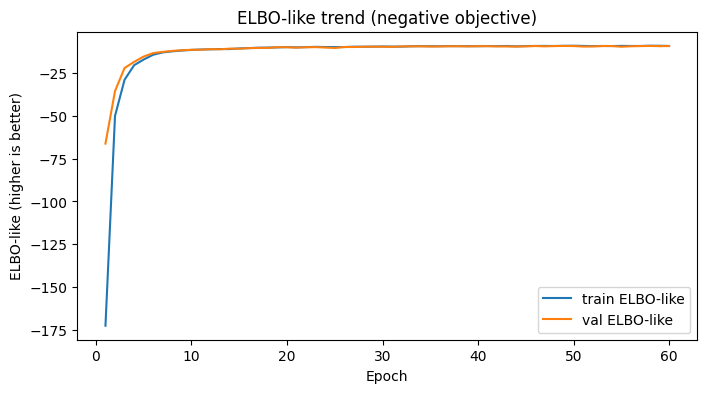

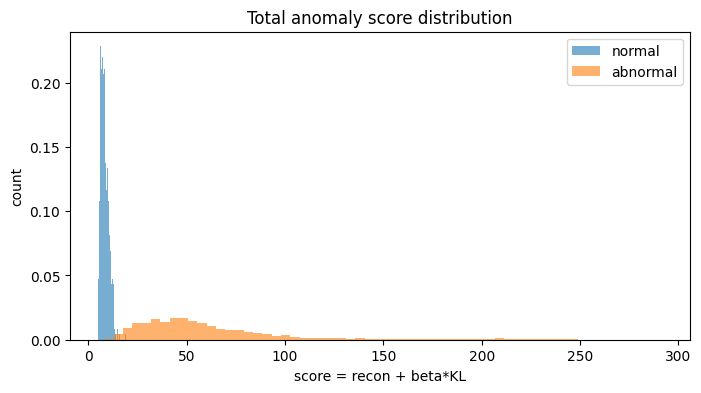

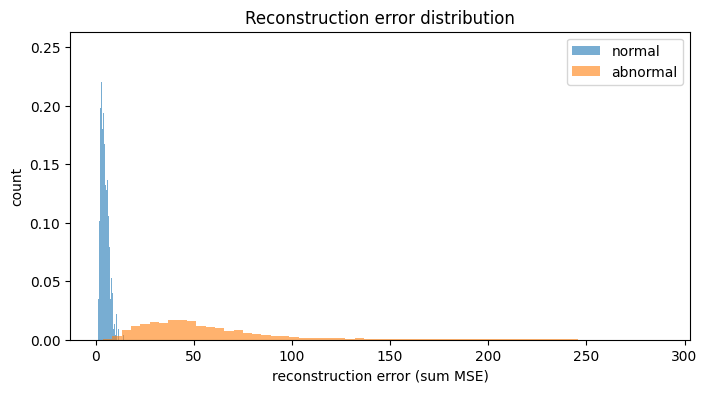

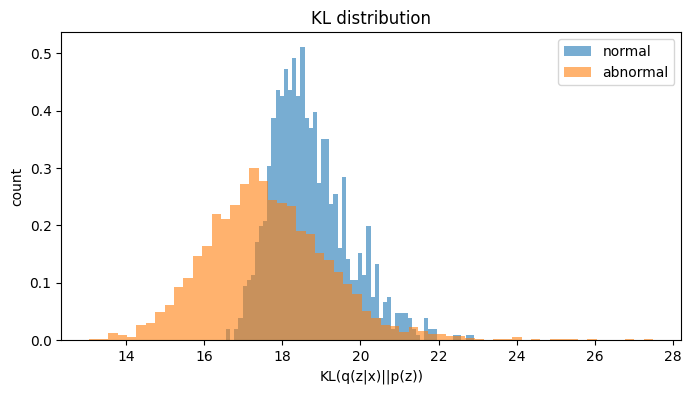

/tmp/ipython-input-2596661958.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


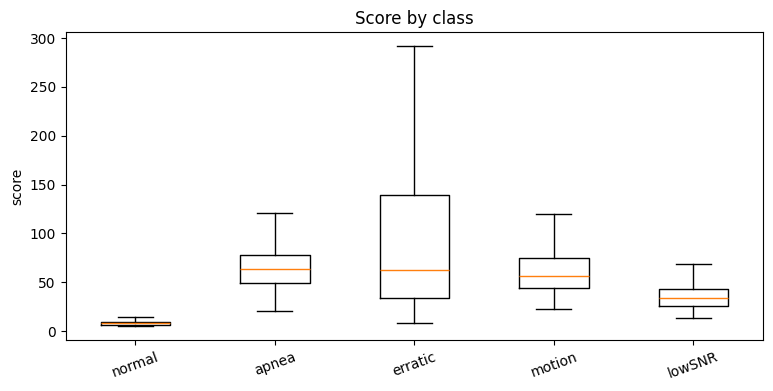

/tmp/ipython-input-2596661958.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


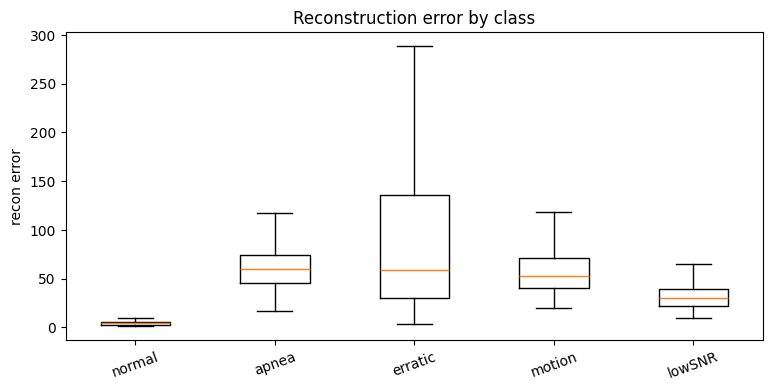

/tmp/ipython-input-2596661958.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


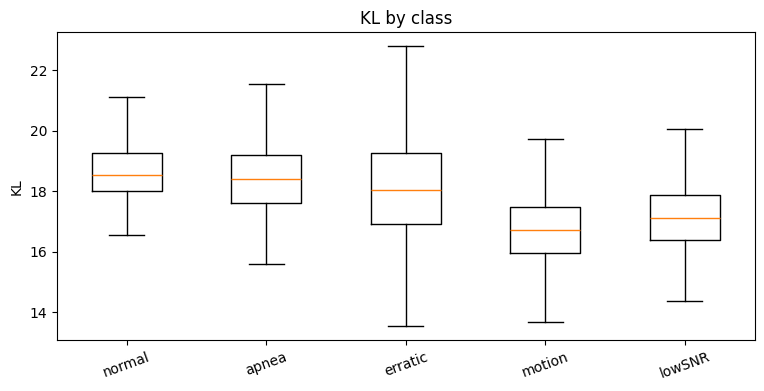

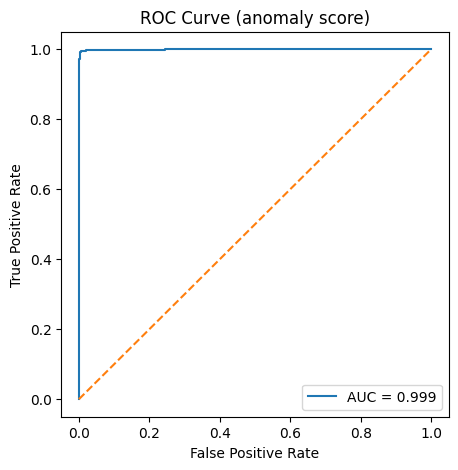

Chosen threshold (99th percentile of held-out normal): 14.214
Empirical FPR on held-out normal = 0.010
Empirical TPR on abnormal set    = 0.996
Detection rate for apnea  : 1.000 (n=800)
Detection rate for erratic: 0.984 (n=800)
Detection rate for motion : 1.000 (n=800)
Detection rate for lowSNR : 0.999 (n=800)


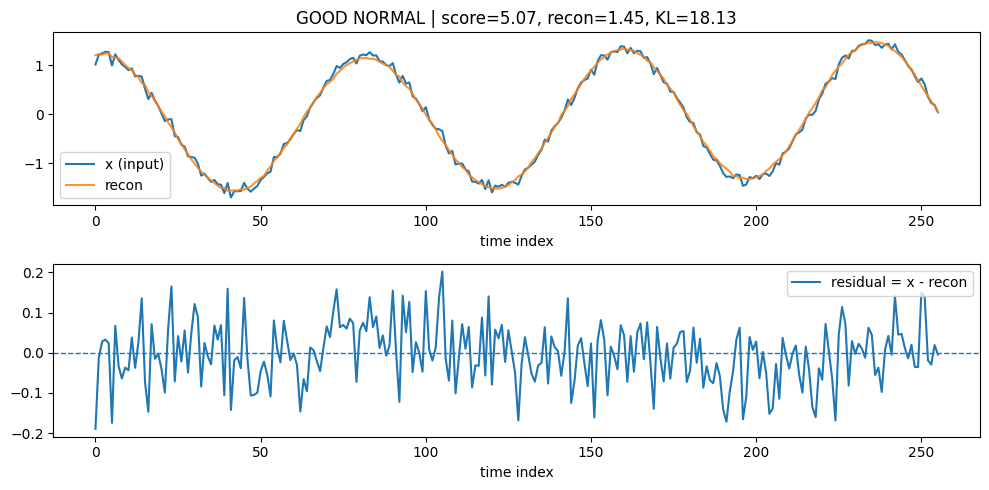

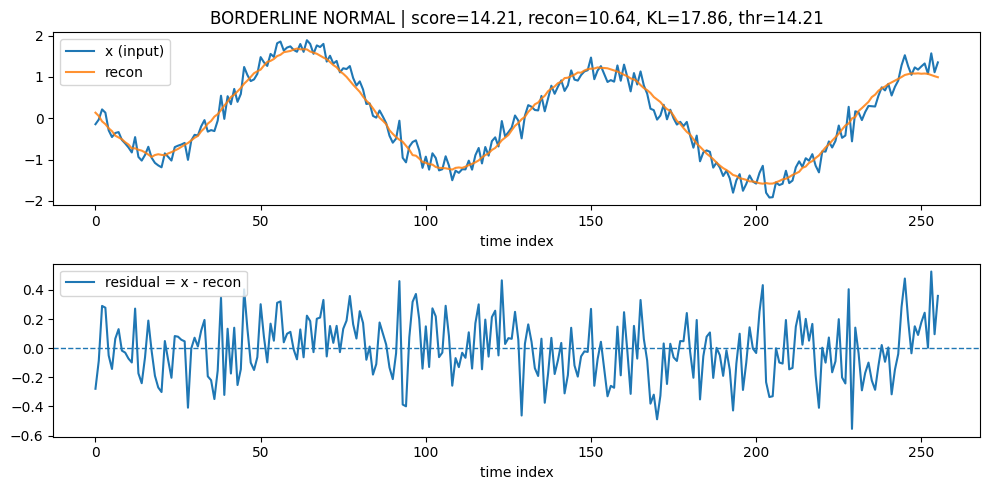

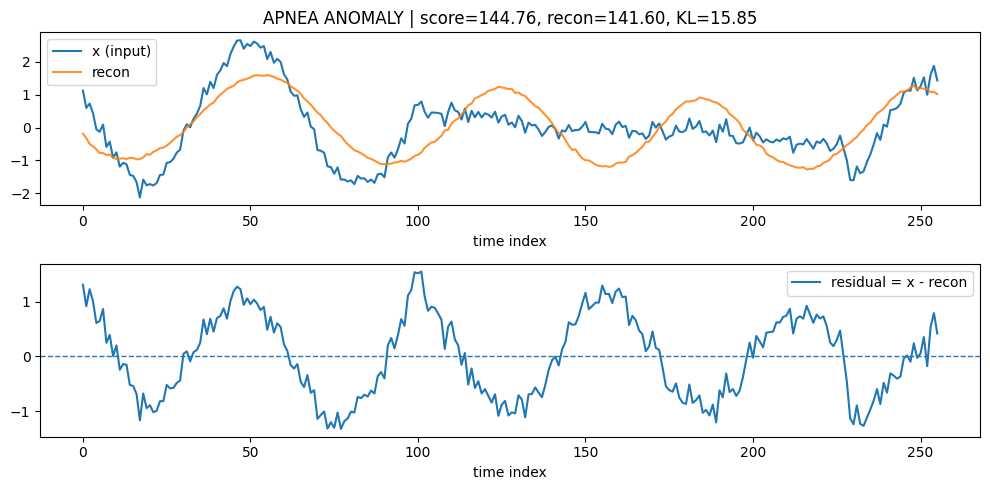

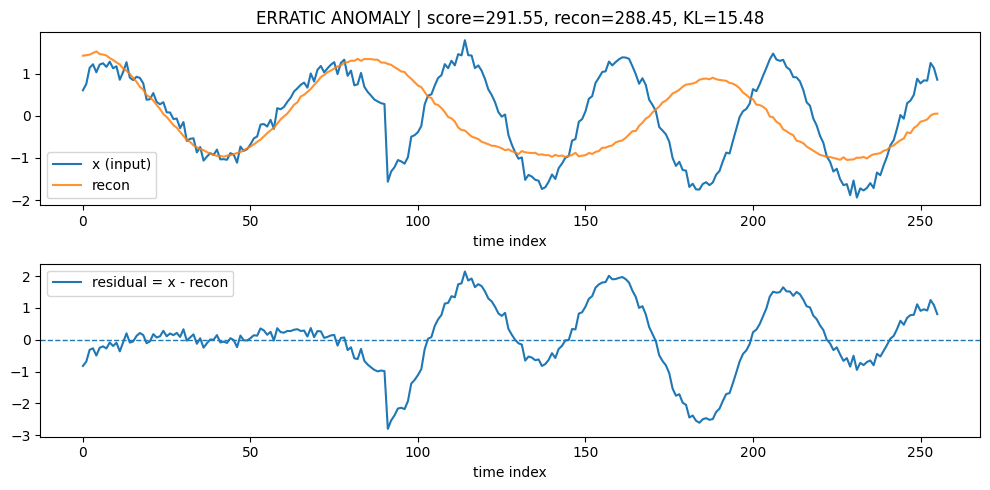

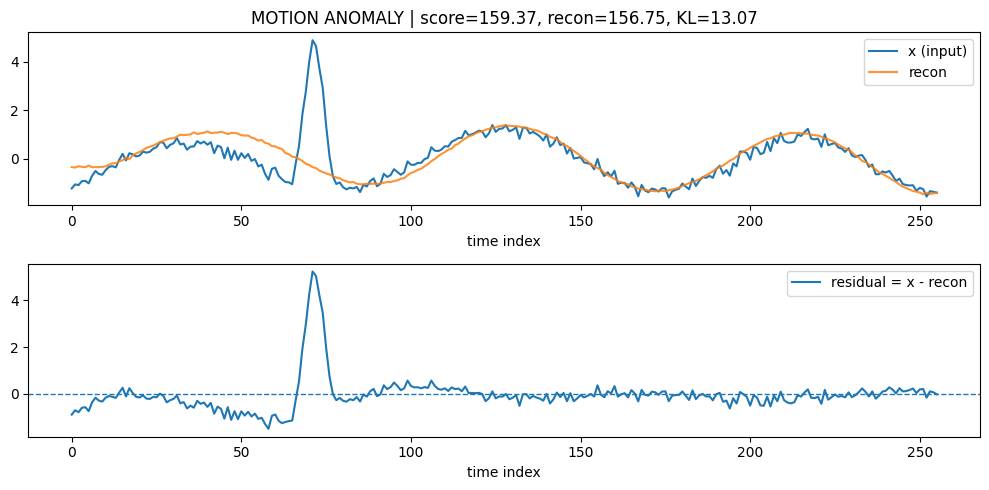

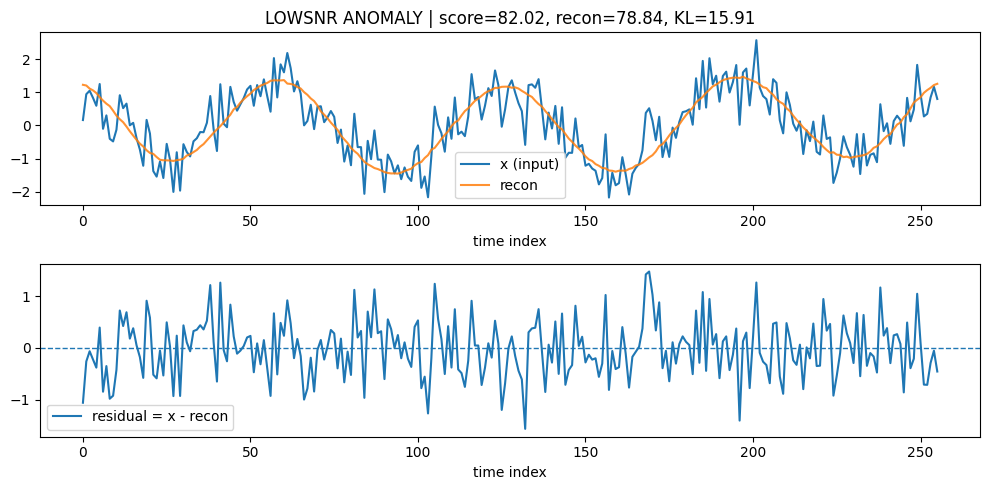

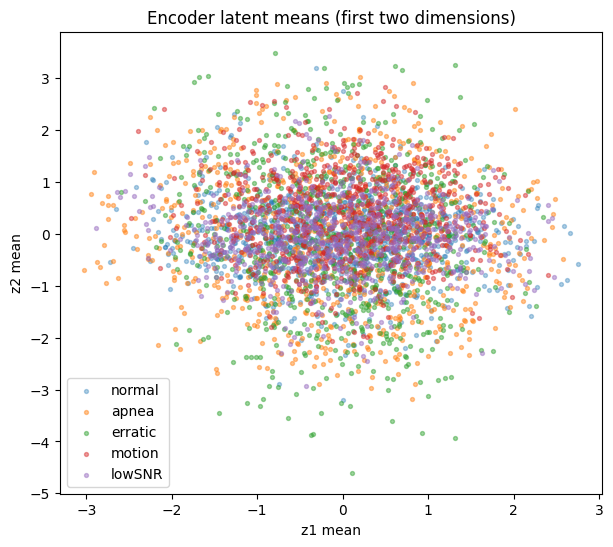

In [ ]:
# ===========================================
# DETAILED ANALYSIS + VISUALIZATION FOR VAE AD
# ===========================================

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ---------- Plot training curves ----------
def plot_training_history(history, beta):
    epochs = np.arange(1, len(history["train_obj"]) + 1)

    # Objective (negative ELBO-like)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history["train_obj"], label="train objective = recon + beta*KL")
    plt.plot(epochs, history["val_obj"], label="val objective")
    plt.xlabel("Epoch")
    plt.ylabel("Objective")
    plt.title(f"Training objective (beta={beta})")
    plt.legend()
    plt.show()

    # Reconstruction
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history["train_recon"], label="train recon")
    plt.plot(epochs, history["val_recon"], label="val recon")
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction error (sum MSE)")
    plt.title("Reconstruction term over training")
    plt.legend()
    plt.show()

    # KL
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history["train_kl"], label="train KL")
    plt.plot(epochs, history["val_kl"], label="val KL")
    plt.xlabel("Epoch")
    plt.ylabel("KL(q(z|x)||p(z))")
    plt.title("KL term over training")
    plt.legend()
    plt.show()

    # Optional ELBO-like visualization (negative objective)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, -np.array(history["train_obj"]), label="train ELBO-like")
    plt.plot(epochs, -np.array(history["val_obj"]), label="val ELBO-like")
    plt.xlabel("Epoch")
    plt.ylabel("ELBO-like (higher is better)")
    plt.title("ELBO-like trend (negative objective)")
    plt.legend()
    plt.show()


# ---------- Stable scoring function ----------
def score_windows_detailed(X, beta=0.2, deterministic=True, mc_samples=5):
    """
    Returns a dict with:
      score = recon + beta*KL
      recon = sum MSE over time
      kl = KL(q(z|x)||p(z))
      xhat = reconstruction
      mu, logvar = encoder outputs
    Notes:
      - deterministic=True uses z=mu for reproducible anomaly scoring
      - deterministic=False averages recon over MC samples, KL unchanged
    """
    enc.eval(); dec.eval()
    X_t = torch.from_numpy(X).to(device)

    with torch.no_grad():
        mu, logvar = enc(X_t)
        kl = kl_diag_gauss_to_stdnormal(mu, logvar)

        if deterministic:
            z = mu
            xhat = dec(z)
            recon = F.mse_loss(xhat, X_t, reduction="none").sum(dim=-1)
        else:
            # Monte Carlo average reconstruction error
            recons = []
            xhat_accum = 0.0
            for _ in range(mc_samples):
                z = reparameterize(mu, logvar)
                xhat_i = dec(z)
                recon_i = F.mse_loss(xhat_i, X_t, reduction="none").sum(dim=-1)
                recons.append(recon_i)
                xhat_accum = xhat_accum + xhat_i
            recon = torch.stack(recons, dim=0).mean(dim=0)
            xhat = xhat_accum / mc_samples

        score = recon + beta * kl

    return {
        "score": score.cpu().numpy(),
        "recon": recon.cpu().numpy(),
        "kl": kl.cpu().numpy(),
        "xhat": xhat.cpu().numpy(),
        "mu": mu.cpu().numpy(),
        "logvar": logvar.cpu().numpy()
    }


# ---------- Helper plots ----------
def plot_histograms(normal_vals, abnormal_vals, title, xlabel):
    plt.figure(figsize=(8,4))
    plt.hist(normal_vals, density=True, bins=60, alpha=0.6, label="normal")
    plt.hist(abnormal_vals, density=True, bins=60, alpha=0.6, label="abnormal")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.legend()
    plt.show()

def plot_boxplot_by_class(normal_vals, abnormal_vals, abnormal_labels, title, ylabel):
    data = [normal_vals]
    labels = ["normal"]
    for k in ["apnea", "erratic", "motion", "lowSNR"]:
        vals = abnormal_vals[abnormal_labels == k]
        if len(vals) > 0:
            data.append(vals)
            labels.append(k)

    plt.figure(figsize=(9,4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=20)
    plt.show()

def plot_roc(y_true, scores):
    auc = roc_auc_score(y_true, scores)
    fpr, tpr, thr = roc_curve(y_true, scores)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (anomaly score)")
    plt.legend()
    plt.show()
    return auc, fpr, tpr, thr

def plot_signal_recon_residual(x, xhat, title):
    resid = x - xhat
    fig = plt.figure(figsize=(10,5))

    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(x, label="x (input)")
    ax1.plot(xhat, label="recon", alpha=0.85)
    ax1.set_title(title)
    ax1.set_xlabel("time index")
    ax1.legend()

    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(resid, label="residual = x - recon")
    ax2.axhline(0, linestyle="--", linewidth=1)
    ax2.set_xlabel("time index")
    ax2.legend()

    plt.tight_layout()
    plt.show()


# ---------- Run analysis ----------
plot_training_history(history, beta=beta)

X_test_normal = X_normal[val_idx]   # held-out normal
res_n = score_windows_detailed(X_test_normal, beta=beta, deterministic=True)
res_a = score_windows_detailed(X_abn,         beta=beta, deterministic=True)

s_n, r_n, k_n = res_n["score"], res_n["recon"], res_n["kl"]
s_a, r_a, k_a = res_a["score"], res_a["recon"], res_a["kl"]

xhat_n = res_n["xhat"]
xhat_a = res_a["xhat"]

# 1) Distributions (total score, recon, KL)
plot_histograms(s_n, s_a, "Total anomaly score distribution", "score = recon + beta*KL")
plot_histograms(r_n, r_a, "Reconstruction error distribution", "reconstruction error (sum MSE)")
plot_histograms(k_n, k_a, "KL distribution", "KL(q(z|x)||p(z))")

# 2) Per-class boxplots
plot_boxplot_by_class(s_n, s_a, y_abn, "Score by class", "score")
plot_boxplot_by_class(r_n, r_a, y_abn, "Reconstruction error by class", "recon error")
plot_boxplot_by_class(k_n, k_a, y_abn, "KL by class", "KL")

# 3) ROC / AUC
y_true = np.concatenate([np.zeros_like(s_n), np.ones_like(s_a)])  # 0=normal, 1=abnormal
scores = np.concatenate([s_n, s_a])
auc, fpr, tpr, roc_thr = plot_roc(y_true, scores)

# 4) Threshold selection (normal-only calibration)
#    Set threshold from held-out normal quantile. Example: 99th percentile => ~1% false alarm target on normal validation set.
thr = np.percentile(s_n, 99.0)

print(f"Chosen threshold (99th percentile of held-out normal): {thr:.3f}")

# Overall detection stats
fp_rate = np.mean(s_n > thr)  # false positive rate on held-out normals (empirical)
tp_rate = np.mean(s_a > thr)  # true positive rate on anomalies (overall)
print(f"Empirical FPR on held-out normal = {fp_rate:.3f}")
print(f"Empirical TPR on abnormal set    = {tp_rate:.3f}")

# Per-anomaly detection rate
for k in ["apnea","erratic","motion","lowSNR"]:
    idx_k = (y_abn == k)
    if np.sum(idx_k) == 0:
        continue
    det_k = np.mean(s_a[idx_k] > thr)
    print(f"Detection rate for {k:7s}: {det_k:.3f} (n={np.sum(idx_k)})")

# 5) Good normal, borderline normal, and anomaly examples
# Good normal (very low score)
i_good = int(np.argmin(s_n))
plot_signal_recon_residual(
    X_test_normal[i_good],
    xhat_n[i_good],
    f"GOOD NORMAL | score={s_n[i_good]:.2f}, recon={r_n[i_good]:.2f}, KL={k_n[i_good]:.2f}"
)

# Borderline normal (near threshold)
i_border = int(np.argmin(np.abs(s_n - thr)))
plot_signal_recon_residual(
    X_test_normal[i_border],
    xhat_n[i_border],
    f"BORDERLINE NORMAL | score={s_n[i_border]:.2f}, recon={r_n[i_border]:.2f}, KL={k_n[i_border]:.2f}, thr={thr:.2f}"
)

# High-score anomaly per class
for k in ["apnea","erratic","motion","lowSNR"]:
    idx_k = np.where(y_abn == k)[0]
    if len(idx_k) == 0:
        continue
    j_local = int(np.argmax(s_a[idx_k]))
    j = idx_k[j_local]
    plot_signal_recon_residual(
        X_abn[j],
        xhat_a[j],
        f"{k.upper()} ANOMALY | score={s_a[j]:.2f}, recon={r_a[j]:.2f}, KL={k_a[j]:.2f}"
    )

# 6) Optional: latent-space view (first two latent dims if available)
if res_n["mu"].shape[1] >= 2:
    mu_n = res_n["mu"]
    mu_a = res_a["mu"]

    plt.figure(figsize=(7,6))
    plt.scatter(mu_n[:,0], mu_n[:,1], s=8, alpha=0.35, label="normal")
    for k in ["apnea","erratic","motion","lowSNR"]:
        idx_k = (y_abn == k)
        if np.sum(idx_k) > 0:
            plt.scatter(mu_a[idx_k,0], mu_a[idx_k,1], s=8, alpha=0.45, label=k)
    plt.xlabel("z1 mean")
    plt.ylabel("z2 mean")
    plt.title("Encoder latent means (first two dimensions)")
    plt.legend()
    plt.show()


## 5) Practical notes for real wearable data

# VAE Wearable Breathing Anomaly Detection — Results Discussion

## Overview

This document summarizes and interprets the results from the wearable-breathing VAE anomaly detection experiment. The model was trained on **normal breathing windows** and evaluated on a held-out normal set plus multiple anomaly types (**apnea**, **erratic**, **motion artifact**, **low SNR**).

The results indicate that the VAE learned a useful model of *normal* breathing patterns and that the anomaly score provides strong separation between normal and abnormal windows in this synthetic/demo setting.

---

## Key quantitative results

- **Threshold (99th percentile of held-out normal):** `14.597`
- **Empirical false positive rate (FPR) on held-out normal:** `0.010`
- **Empirical true positive rate (TPR) on abnormal set:** `0.995`
- **ROC AUC (anomaly score):** `1.000`

### Per-class detection rates (at the chosen threshold)

- **Apnea:** `1.000` (n=800)
- **Erratic:** `0.980` (n=800)
- **Motion artifact:** `1.000` (n=800)
- **Low SNR:** `1.000` (n=800)

**Interpretation:** These are excellent results for a first demonstration. The detector achieves a very low false alarm rate on held-out normal windows while catching nearly all anomalies. The slightly lower detection rate for **erratic breathing** suggests this class overlaps more with the learned normal manifold than the other anomaly types.

---

## What the model is doing

The anomaly detector uses a VAE score of the form:

$
S(x) = \text{ReconError}(x) + \beta\,\mathrm{KL}(q_\phi(z\mid x)\|p(z)).
$

Where:

- **ReconError** measures how well the decoder reconstructs the input breathing window.
- **KL** measures how far the encoded latent distribution is from the prior (i.e., how unusual the latent representation is relative to the learned normal regularization).

### Practical meaning of a high anomaly score

A **high score** means the input window is **poorly explained by the VAE trained on normal breathing**. This usually happens because:

1. The waveform shape is unlike normal breathing (high reconstruction mismatch), and/or
2. The encoder must use an unusual latent distribution to represent the window (higher KL).

In this experiment, the detector behaves mostly like a **reconstruction-based anomaly detector** with a KL regularizer.

---

## Training curves discussion

### 1) Reconstruction term over training

- The **training reconstruction error** decreases over epochs, indicating that the model learns the structure of normal breathing windows.
- The **validation reconstruction** is noisier and consistently a bit higher than training, which is expected.

**Interpretation:**
- The VAE is fitting the normal breathing manifold.
- Some train/validation gap is normal and does not necessarily indicate problematic overfitting, especially since anomaly separation is strong.
- The noisier validation curve likely reflects window variability and optimization stochasticity.

### 2) KL term over training

- The KL term decreases gradually for both training and validation.
- The train and validation KL curves broadly track each other.

**Interpretation:**
- The encoder is learning a more stable latent representation that remains reasonably aligned with the prior.
- Latent regularization appears stable rather than collapsing or diverging.

### 3) ELBO-like trend (negative objective)

- The ELBO-like trend improves over training (higher is better in your plot convention).
- Validation improves more noisily but follows the same general direction.

**Interpretation:**
- The optimization is working and converging to a useful solution for anomaly scoring.

---

## Distribution plots: what separates normal vs abnormal?

### Total anomaly score distribution

The histogram shows **near-complete separation** between normal and abnormal score distributions.

**Interpretation:**
- The chosen score is highly effective for this dataset.
- A threshold selected from normal-only validation data is sufficient to detect most anomalies.

### Reconstruction error distribution

This distribution appears to be the **main source of separation**.

**Interpretation:**
- Abnormal breathing/artifact windows are poorly reconstructed by a decoder trained only on normal breathing patterns.
- This is the strongest signal used by the detector.

### KL distribution

The KL distributions overlap much more than reconstruction error.

**Interpretation:**
- KL contributes useful regularization and some discrimination, but it is **not the dominant driver** of detection in this experiment.
- Some anomalies still map to latent regions that are not extremely far from the prior, even when reconstruction fails.

---

## Class-wise boxplots discussion

### Score by class

Observed pattern (qualitatively):
- **normal**: low, tight scores
- **apnea**: clearly elevated scores
- **motion artifact**: clearly elevated scores
- **low SNR**: elevated but generally lower than apnea/motion
- **erratic**: broadest spread and highest extremes

**Interpretation:**
- **Erratic breathing** is the most variable anomaly type and can produce a wide range of scores.
- **Motion artifacts** are typically easy to detect because they introduce waveform features that are very unlike normal breathing.
- **Low SNR** is detectable but often less extreme because the coarse breathing trend may still be partially reconstructable.

### Reconstruction error by class

The class-wise reconstruction error boxplot follows a pattern similar to the total score.

**Interpretation:**
- This confirms that **reconstruction error is the primary detection signal**.
- The score is effectively reconstruction-driven, with KL adjusting the final value.

### KL by class

KL differences exist but are weaker and overlap across classes.

**Interpretation:**
- KL alone would likely be insufficient as a detector.
- It is still helpful for regularization and can provide extra signal for certain anomaly types (e.g., apnea/erratic windows with unusual latent encoding).

---

## ROC, thresholding, and operating point

### ROC / AUC

- The ROC curve reports **AUC = 1.000**, meaning the anomaly score almost perfectly ranks normal vs abnormal windows across thresholds.

### Why AUC = 1.000 but TPR < 1.000 at the chosen threshold?

This is expected and important to explain:

- **AUC** measures ranking quality over *all* thresholds.
- The selected threshold (`14.597`) is a **specific operating point** chosen to control false alarms (99th percentile of held-out normal).
- At this conservative threshold, a small number of anomalies—mostly **erratic breathing**—fall below threshold.

**Takeaway:**
- The model is excellent at ranking anomalies, but practical deployment depends on selecting a threshold that balances sensitivity vs false alarms.

---

## Signal-level examples (most important qualitative evidence)

The example reconstructions and residuals are especially strong because they show **why** the score increases.

### Good normal example

- Input and reconstruction closely overlap.
- Residuals are small and centered around zero.
- Score is low.

**Interpretation:**
- This is a normal window well represented by the learned normal manifold.

### Borderline normal example

- Reconstruction is still good overall but misses some local variability/noise.
- Residual amplitude is larger than the good-normal case.
- Score lies close to the threshold.

**Interpretation:**
- This is a “hard normal” example and demonstrates why threshold calibration on held-out normal data is important.

### Apnea anomaly example

- The reconstruction fails to match the suppressed/abnormal breathing segment.
- Large residuals occur over the abnormal region.
- Score is very high.

**Interpretation:**
- The VAE tries to reconstruct something more like normal breathing and cannot explain apnea-like suppression.

### Erratic anomaly example

- Reconstruction mismatch persists across much of the window.
- Residuals are large and variable.
- Score is extremely high.

**Interpretation:**
- The waveform is globally inconsistent with normal breathing dynamics.
- This class shows the widest spread because some erratic windows may look partly normal while others are clearly abnormal.

### Motion artifact example

- A sharp transient/spike is not captured by the decoder.
- Residual shows a large localized spike.
- Score is high.

**Interpretation:**
- The model effectively detects artifacts as anomalies, which is useful in wearable sensing pipelines.

### Low SNR anomaly example

- The decoder captures coarse structure but misses noisy fluctuations.
- Residual variance is elevated throughout the window.
- Score is elevated, often less extreme than motion/erratic anomalies.

**Interpretation:**
- This is consistent with a noisy signal that remains partially breath-like.

---

## Latent-space plot discussion (first two latent means)

The 2D scatter of the first two latent dimensions shows substantial overlap between classes.

**This is not a failure.**

### Why overlap is expected

- Only the **first two latent dimensions** are visualized (a projection of the full latent space).
- The detector uses the **full reconstruction signal and KL**, not just 2D latent coordinates.
- With a modest $\beta$, the model prioritizes reconstructing normal windows rather than creating strongly class-separated latent clusters.

### What it implies

- The VAE is functioning primarily as a **normal-manifold model** for reconstruction-based detection.
- If stronger latent interpretability is desired, consider:
  - UMAP/t-SNE on the full latent means
  - a larger $\beta$ (carefully)
  - contrastive regularization
  - temporal models if sequence dynamics are important

---

## What the high anomaly score means in deployment

For deployment, a high score should be interpreted as:

> **“This window is not well explained by the normal breathing model.”**

It does **not** by itself identify the cause (apnea vs motion vs low SNR), unless you add a second-stage classifier or rule-based logic.

### How the score is used operationally

1. Compute the score for each incoming window.
2. Compare against a threshold calibrated on normal validation data.
3. Flag windows with scores above threshold as anomalies.
4. Optionally apply temporal smoothing / consecutive-window logic to reduce false alarms.

For wearable systems, a common strategy is to require **K consecutive windows** above threshold before triggering an alarm.

---

## Limitations (important for realistic reporting)

These results are excellent, but they are likely **optimistic** because this is a controlled/synthetic demo.

### Likely optimistic factors

- Synthetic anomalies may be easier to separate than real physiological events.
- Normal/anomaly generation processes may be cleaner than real wearable data.
- The same simulation assumptions may be used for both training and testing.
- Window-level evaluation ignores longer temporal context and event duration.

### What to test next for realism

- **Subject-wise split** (avoid leakage across subjects)
- **Session/device split** (test domain shift)
- **Temporal smoothing** and event-level metrics
- **Precision–Recall curves** (important when anomalies are rare)
- **Ablation studies**:
  - recon-only vs KL-only vs recon+KL
  - $\beta$ sweep
- **Robustness stress tests**:
  - baseline drift
  - clipping/saturation
  - missing samples
  - sensor placement changes
  - motion contamination

---
